In [1]:
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dlib
import time

from sklearn.externals import joblib

from sklearn.metrics import confusion_matrix

In [2]:
# Dlib face detector
detector = dlib.get_frontal_face_detector()

# Facial landmarks detector
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# get data from file
data = pd.read_csv('data/fer2013.csv')

In [3]:
'''
0 - Anger
1 - Disgust
2 - Fear
3 - Happiness
4 - Sadness
5 - Surprise
6 - Neutral
'''

classes = [
    'Anger',
    'Disgust',
    'Fear',
    'Happiness',
    'Sadness',
    'Surprise',
    'Neutral',
]

D = data
# print(data.groupby('Usage').count())

def get_landmarks(_image):
    """
    takes in an image, detects face in it,
    if face is detected then finds facial landmarks of that face,
    extracts some features as explained in code
    return : list of features corresponding to the detected face,
             if no face is detected, returns "error"
    """
    image = _image.copy()
    detections = detector(image, 1)
    
    # for all detected face instances individually
    for k, d in enumerate(detections):
        
        # get Facial Landmarks with the predictor class
        shape = predictor(image, d)
        
        xlist = []
        ylist = []
        # store X and Y coordinates in two lists
        for i in range(1, 68):
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
                
#         xmean = np.mean(xlist) #Get the mean of both axes to determine centre of gravity
#         ymean = np.mean(ylist)
        xmean = xlist[29]
        ymean = ylist[29]
        
        # get distance between each point and the central point in both axes
        xcentral = [(x - xmean) for x in xlist]
        ycentral = [(y - ymean) for y in ylist]
        
        # point 29 - nose tip
        # point 26 - middle point b/w two eyes
        
        # get angle that nose line makes with vertical, this for correcting tilted faces.
        angle_nose = np.arctan2((ylist[26] - ymean), (xlist[26] - xmean)) * 180 / np.pi
        if angle_nose < 0:
            angle_nose += 90
        else:
            angle_nose -= 90
        
        # landmarks_vectorised is the feature vector corresponding to the face
        """
        landmarks_vectorised is of the form
        [p1_x_rel, p1_y_rel, dist(p, centre), angle()]
        """
        landmarks_vectorised = []
        for i in range(0, 67):
            """
            rx - x coordinate of relative position of a point w.r.t central point
            ry - y coordinate of relative position of a point w.r.t central point
            x - absolute x coordinate
            y - absolute y coordinate
            """
            
            rx = xcentral[i]
            ry = ycentral[i]
            x = xlist[i]
            y = ylist[i]
        
            landmarks_vectorised.append(rx)
            landmarks_vectorised.append(ry)

            # calculate length of point i from central point
            dist = np.linalg.norm(np.array([rx, ry]))
            landmarks_vectorised.append(dist)

            # get the angle the vector describes relative to the image, 
            # corrected for the offset that the nosebrigde has when the face is titled
            anglerelative = (np.arctan2((-ry), (-rx)) * 180 / np.pi) - angle_nose
            landmarks_vectorised.append(anglerelative)
        
    if len(detections) < 1: 
        landmarks_vectorised = "error"     
    
    return landmarks_vectorised


def make_sets():
    """
    return: creates feature matrix by appending feature vector of 
            each image.
    """
    training_data = []
    test_data = []
    training_label = []
    test_label = []
    
    #Append data to training and prediction list, and generate labels 0-7
    index = 0
    
    start_time = time.time()
    
    for item in training_image:
        # image = cv.imread(item) #open image
        # gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY) #convert to grayscale
        # clahe_image = clahe.apply(gray)
#         print(index)
        landmarks_vectorised = get_landmarks(item)
        if landmarks_vectorised == "error":
            pass
        else:
            training_data.append(landmarks_vectorised) #append image array to training data list
            training_label.append(training_label_full[index])
            
        index += 1
        
    print('train - ', time.time() - start_time)
    
    index = 0
    for item in test_image:
        # image = cv.imread(item)
        # gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        # clahe_image = clahe.apply(gray)
#         print(index)
        landmarks_vectorised = get_landmarks(item)
        if landmarks_vectorised == "error":
            pass
        else:
            test_data.append(landmarks_vectorised)
            test_label.append(test_label_full[index])
            
        index += 1
        
    print('test - ', time.time() - start_time)

    return training_data, test_data, training_label, test_label


def plot_confusion_matrix(cm, classes=classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized ' + title
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
# list of images for model training
training_image = []
# corresponding labels
training_label_full = []

# list of images for model testing
test_image = []
# corresponding labels
test_label_full = []

start_time = time.time()
print('reading data..')

# read data and reshape the pixel row from (48*48, ) to (48, 48)
# dataset contains images labeled as 'Training', 'PrivateTest' and 'PublicTest'
# images labeled 'Training' are used for training the model and rest for testing.
for index, row in D.iterrows():
    if row['Usage'] == 'Training':
        training_image.append(np.reshape(np.array(row['pixels'].split(), dtype=np.uint8), (48, 48)))
        training_label_full.append(row['emotion'])
    else:
        test_image.append(np.reshape(np.array(row['pixels'].split(), dtype=np.uint8), (48, 48)))
        test_label_full.append(row['emotion'])
        
print('time taken for reading data - %f sec' % (time.time() - start_time))


print('starting feature extraction..')
start_time = time.time()
train_data, test_data, training_label, test_label = make_sets()
print('feature extraction done in %f sec' % (time.time() - start_time))

print(len(train_data), len(training_label))

# pd.DataFrame(train_data)
# pd.DataFrame(test_data)

reading data..
time taken for reading data - 44.055587 sec
starting feature extraction..
('train - ', 87.69221687316895)
('test - ', 109.47682690620422)
feature extraction done in 109.477084 sec
(19863, 19863)


In [9]:
train_data = np.asarray(train_data)
training_label = np.asarray(training_label)

test_data = np.asarray(test_data)
test_label = np.asarray(test_label)

MLP clf prediction done in 0.035260 sec
Training accuracy (using MLP) - 50.577742 
Confusion matrix of prediction using MLP classifier
[[ 268    1   57   93   39   36  151]
 [  43    1    5   12    4    5   15]
 [ 104    0   80  102   64  119  173]
 [  43    1   47 1145   35   21   83]
 [ 115    1   54   96   79   33  290]
 [  45    0   33   70    5  381   68]
 [ 121    0   49   91   68   46  541]]


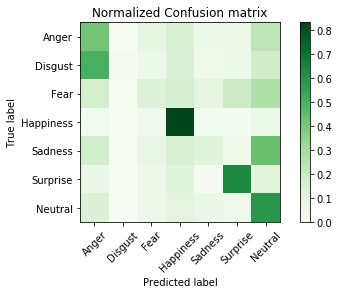

In [10]:
##### Multilayer Perceptron Classifier

from sklearn.neural_network import MLPClassifier

train_net = False
model_path_MLP = 'trained_models/MLP_100_clf_temp.pkl'

if train_net:
    # training
    start_time = time.time()
    nn_clf = MLPClassifier(solver='lbfgs', alpha=1e-6, hidden_layer_sizes=(100), random_state=1, max_iter=500)
    nn_clf.fit(train_data, training_label)
    print('MLP classifier fit done in %f sec' % (time.time() - start_time))
    
    # save model
    joblib.dump(nn_clf, model_path_MLP, compress=9)

## prediction
start_time = time.time()
nn_clf = joblib.load(model_path_MLP)
nn_predicted_labels = nn_clf.predict(test_data)
print('MLP clf prediction done in %f sec' % (time.time() - start_time))
print('Training accuracy (using MLP) - %f ' % (np.mean(nn_predicted_labels == test_label) * 100))

cm = confusion_matrix(test_label, nn_predicted_labels)
print('Confusion matrix of prediction using MLP classifier')
print(cm)
plot_confusion_matrix(cm)    
plt.show()

starting XGB prediction..
XGB prediction done in 0.237642 sec
Training accuracy (using XGB) - 52.908980
Confusion matrix of prediction using MLP classifier
[[ 185    2   29  138   40   52  199]
 [  14    2    9   20    6    3   31]
 [  66    0   72  114   58   91  241]
 [  15    0   26 1201   19   16   98]
 [  46    1   31  124  101   22  343]
 [  19    1   35   72    9  369   97]
 [  46    0    9   85   72   24  680]]


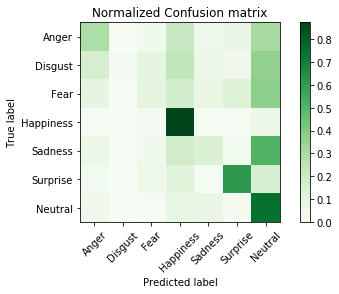

In [20]:
from xgboost import XGBClassifier

train_XGB = False
model_path_XGB = 'trained_models/XGB.pkl'

if train_XGB:
    # training
    # training
    start_time = time.time()
    xgb_clf = XGBClassifier()
    print('training XGB classifier..')
    xgb_clf.fit(train_data, training_label)
    print('XGB classifier fit done in %f sec' % (time.time() - start_time))
    
    # save model
    joblib.dump(xgb_clf, model_path_XGB, compress=9)
    
# prediction
start_time = time.time()
xgb_clf = joblib.load(model_path_XGB)
print('starting XGB prediction..')
xgb_predicted_labels = xgb_clf.predict(test_data)
print('XGB prediction done in %f sec' % (time.time() - start_time))

print('Training accuracy (using XGB) - %f' % (np.mean(xgb_predicted_labels == test_label) * 100))

cm = confusion_matrix(test_label, xgb_predicted_labels)
print('Confusion matrix of prediction using MLP classifier')
print(cm)
plot_confusion_matrix(cm)    
plt.show()

In [60]:
from sklearn import svm

train_svm = False
model_path_SVC = 'trained_models/svc_rbf.pkl'

if train_svm:
    # training
    start_time = time.time()
    clf = svm.SVC(kernel='rbf', gamma=2)
    clf.fit(train_data, training_label)
    print('SVC with RBF kernel fit done in %f sec' % (time.time() - start_time))
    
    # save model
    joblib.dump(clf, model_path_SVC, compress=9)
    
# prediction
start_time = time.time()
scv_rbf_clf = joblib.load(model_path_SVC)
svc_predicted_labels = scv_rbf_clf.predict(test_data)
print('SVC prediction done in %f sec' % (time.time() - start_time))
print('Training accuracy (using kernel SVC) - %f' % (np.mean(svc_predicted_labels == test_label) * 100))

SVC prediction done in 29.750270 sec
Training accuracy (using kernel SVC) - 27.873505


training random forest classifier with 200 estimators..
random forest training done in 30.150005 sec
starting prediction using random forest classifier..
Random forest prediction done in 0.635738 sec
[3 6 6 ..., 2 6 2]
Training accuracy (using random forest) - 56.274073
Confusion matrix of prediction using MLP classifier
[[ 181    1   35  147   62   36  183]
 [  10   32    6   15    2    3   17]
 [  58    0  166  112   67   64  175]
 [  19    0   25 1190   23   20   98]
 [  45    0   42  114  145   19  303]
 [  18    0   28   63   14  421   58]
 [  32    0   36   94   90   23  641]]


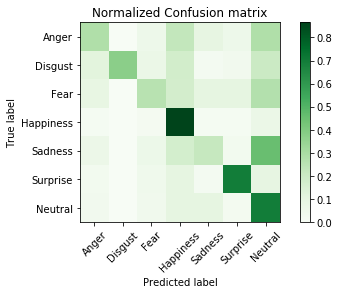

In [31]:
### random forest classifier

from sklearn.ensemble import RandomForestClassifier

train_random_forest = True
model_path_random_forest = 'trained_models/random_forest_200.pkl'

if train_random_forest:
    # training
    start_time = time.time()
    n_estimators = 200
    print('training random forest classifier with %d estimators..' % (n_estimators))
    rf_clf = RandomForestClassifier(n_estimators=n_estimators)
    rf_clf.fit(train_data, training_label)
    print('random forest training done in %f sec' % (time.time() - start_time))
    
    # save model
    joblib.dump(rf_clf, model_path_random_forest, compress=9)
    
# prediction
rf_clf = joblib.load(model_path_random_forest)

start_time = time.time()

print('starting prediction using random forest classifier..')
rf_predicted_labels = rf_clf.predict(test_data)
print('Random forest prediction done in %f sec' % (time.time() - start_time))

print(rf_predicted_labels)
print('Training accuracy (using random forest) - %f' % (np.mean(rf_predicted_labels == test_label) * 100))

cm = confusion_matrix(test_label, rf_predicted_labels)
print('Confusion matrix of prediction using MLP classifier')
print(cm)
plot_confusion_matrix(cm)    
plt.show()

training adaboost classifier with 10 estimators..
adaboost training done in 192.895985 sec
starting prediction using adaboost classifier..
adaboost prediction done in 3.588384 sec
Training accuracy (using adaboost classifier) - 55.868640
Confusion matrix of prediction using MLP classifier
[[ 165    0   26  192   40   22  200]
 [   5   30    4   21    3    5   17]
 [  45    0  152  148   43   65  189]
 [  13    1   11 1230   21   15   84]
 [  35    0   28  147  118   11  329]
 [  15    0   24   70   19  400   74]
 [  39    0    9  141   52   14  661]]


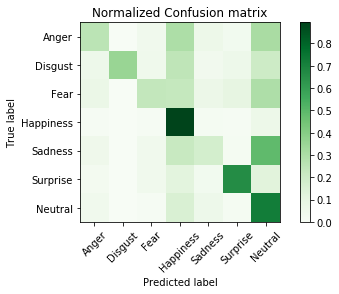

In [25]:
## Adaboost classifier

from sklearn.ensemble import AdaBoostClassifier

train_adaboost = False
model_path_adaboost = 'trained_models/adaboost_rf_10.pkl'

# xgb_clf = joblib.load(model_path_XGB)
rf_clf = joblib.load(model_path_random_forest)

if train_adaboost:
    # training
    start_time = time.time()
    n_estimators = 10
    print('training adaboost classifier with %d estimators..' % (n_estimators))
    adaboost_clf = AdaBoostClassifier(base_estimator=rf_clf, n_estimators=n_estimators)
    adaboost_clf.fit(train_data, training_label)
    print('adaboost training done in %f sec' % (time.time() - start_time))
    
    # save model
    joblib.dump(adaboost_clf, model_path_adaboost, compress=9)
    
# prediction
adaboost_clf = joblib.load(model_path_adaboost)
start_time = time.time()
print('starting prediction using adaboost classifier..')
adaboost_predicted_labels = adaboost_clf.predict(test_data)
print('adaboost prediction done in %f sec' % (time.time() - start_time))

print('Training accuracy (using adaboost classifier) - %f' % (np.mean(adaboost_predicted_labels == test_label) * 100))

cm = confusion_matrix(test_label, adaboost_predicted_labels)
print('Confusion matrix of prediction using MLP classifier')
print(cm)
plot_confusion_matrix(cm)    
plt.show()